In [23]:
import os, sys
import numpy as np
import pandas as pd
import librosa
import IPython.display as ipd
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import fma_utilities as utils
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
# Directory where mp3 are stored.
AUDIO_DIR = '../../dataset_process/data/fma_small/'

# Load metadata and features.
tracks = utils.load('../../dataset_process/data/fma_metadata/tracks.csv')
genres = utils.load('../../dataset_process/data/fma_metadata/genres.csv')
features = utils.load('../../dataset_process/data/fma_metadata/features.csv')
echonest = utils.load('../../dataset_process/data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [3]:
def get_trackID_from_path(path):
    return int(path.split('\\')[-1].split('.')[0])

def get_track_top_genre(trackID):
    return tracks.loc[trackID]['track']['genre_top']

In [41]:
# Get the base directory
basedir = os.getcwd()
dirname = basedir+ "\\..\\..\\dataset_process\\data\\fma_small\\"

# Save audio paths and labels
audio_paths = []
# audio_dict = {}
audio_label = []
# Print all the files in different directories
for root, dirs, files in os.walk(dirname, topdown=False):
    for filenames in files:
        if filenames.find('.mp3') != -1:

            path = os.path.join(root, filenames)
            genre = get_track_top_genre(get_trackID_from_path(path))
            # print(filenames, genre)
            audio_paths.append(path)
            filenames = filenames.split('.', 1)
            filenames = filenames[0]
            
            audio_label.append(genre)
audio_paths = np.array(audio_paths)
audio_label = np.array(audio_label)
audio_paths, audio_label = shuffle(audio_paths, audio_label, random_state=47)
audio_paths.shape, audio_label.shape

((8000,), (8000,))

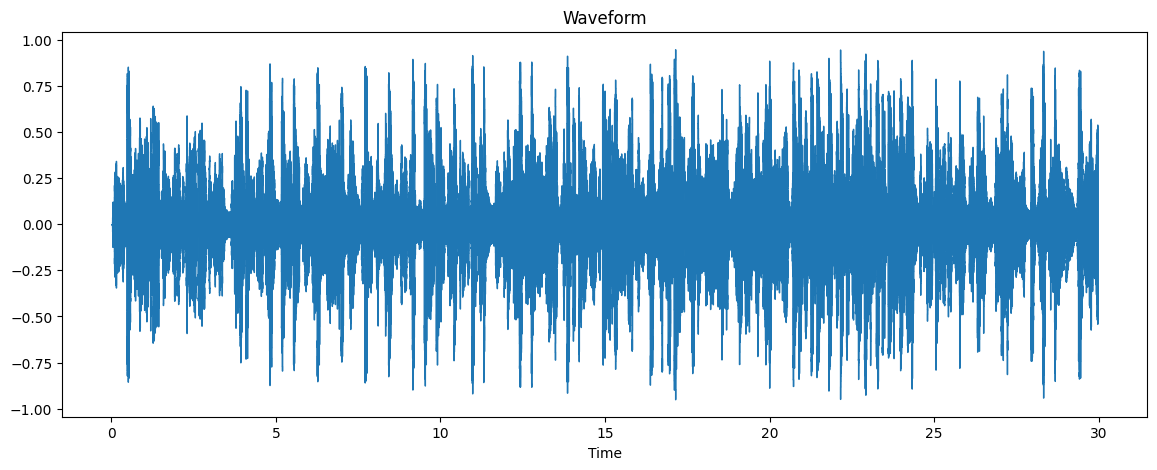

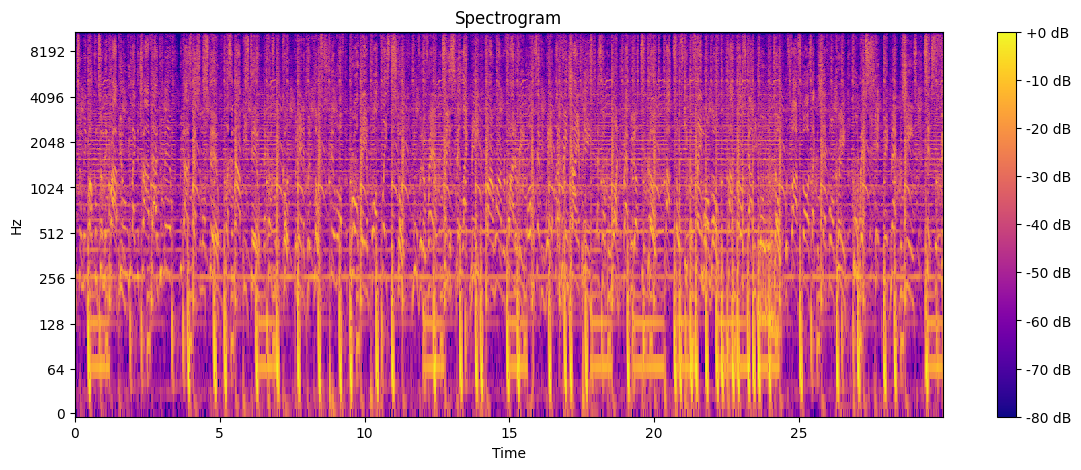

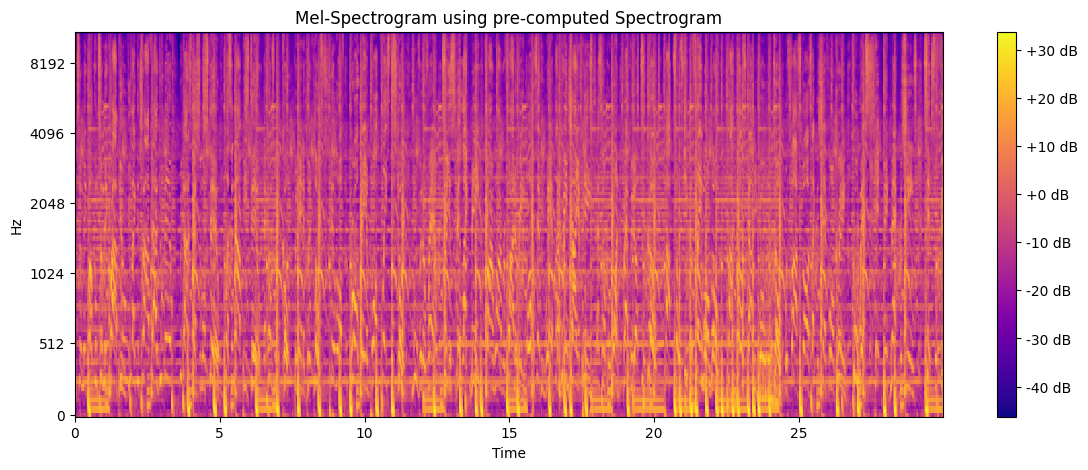

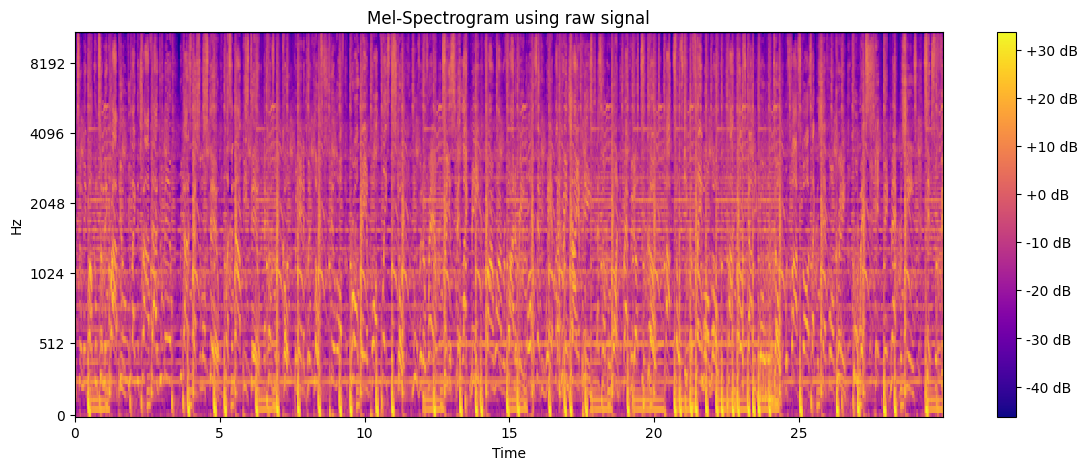

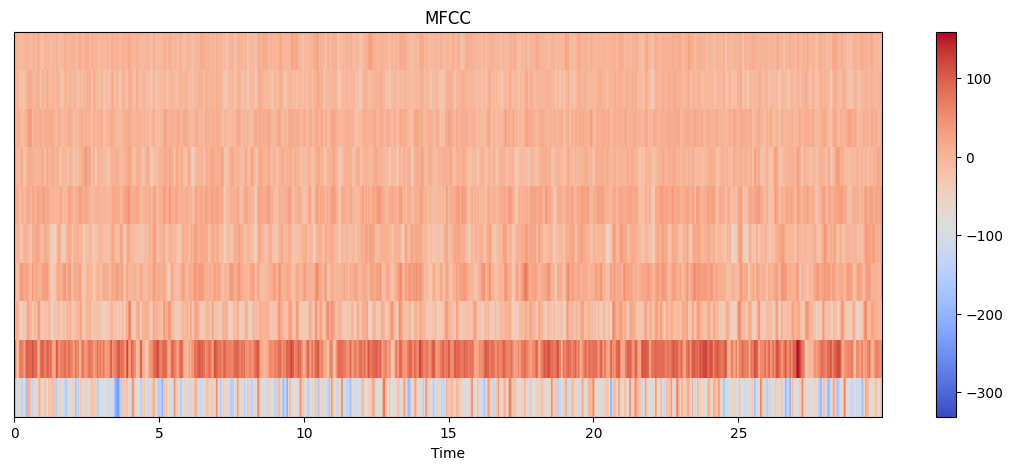

(660984,)
108831


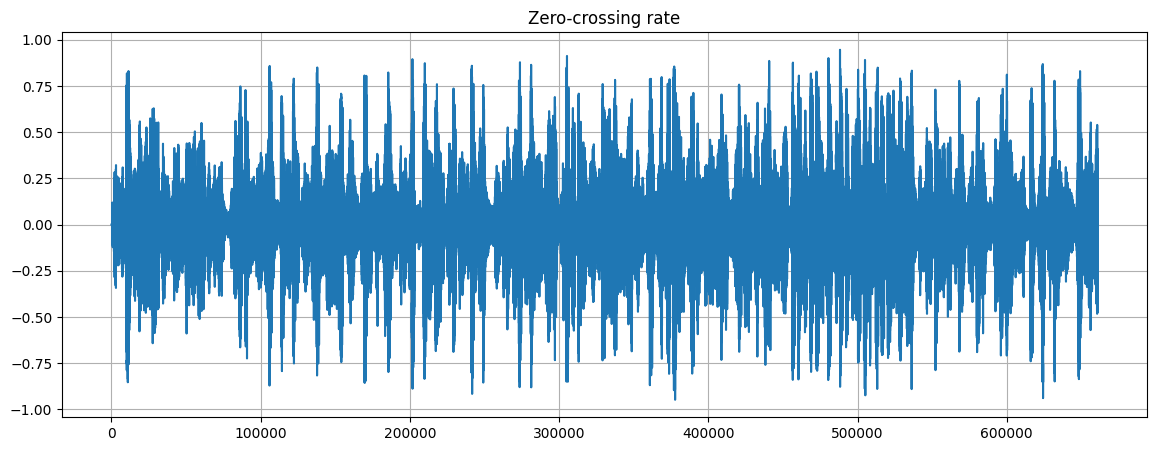

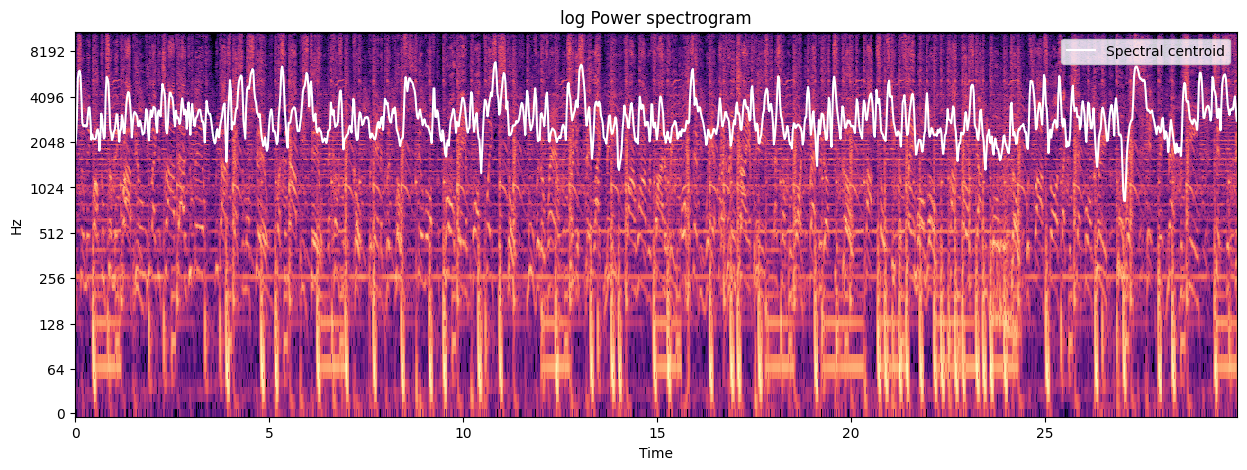

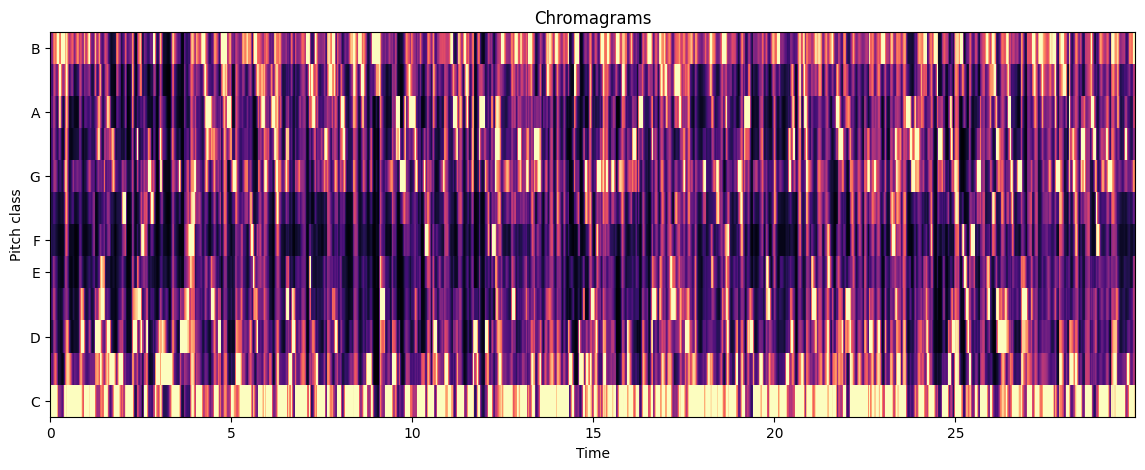

In [46]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

# Replace 'audio_1' with your audio file path
audio_1 = '../../dataset_process/data/fma_small/000/000002.mp3'
y, sr = librosa.load(audio_1)

# Display waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

# Display Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='plasma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

# Display Mel-Spectrogram using pre-computed Spectrogram
S = np.abs(librosa.stft(y))**2
mel = librosa.feature.melspectrogram(S=S, sr=sr)
mel_db = librosa.power_to_db(mel)
plt.figure(figsize=(14, 5))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='plasma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram using pre-computed Spectrogram')
plt.show()

# Display Mel-Spectrogram using raw signal
mel_raw = librosa.feature.melspectrogram(y=y, sr=sr)
mel_db_raw = librosa.power_to_db(mel_raw)
plt.figure(figsize=(14, 5))
librosa.display.specshow(mel_db_raw, sr=sr, x_axis='time', y_axis='mel', cmap='plasma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram using raw signal')
plt.show()

# Display MFCC (Mel-frequency cepstral coefficients)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()

# Display Zero-crossing rate
plt.figure(figsize=(14, 5))
plt.plot(y)
plt.grid()
zc = librosa.zero_crossings(y, pad=False)
print(zc.shape)
print(sum(zc))
plt.title('Zero-crossing rate')
plt.show()

# Display Spectral centroid using raw signal
# Spectral centroid using raw signal
sp_cen = librosa.feature.spectral_centroid(y=y, sr=sr)
# print(sp_cen.shape)
X = librosa.stft(y)
times = librosa.times_like(sp_cen)
fig, ax = plt.subplots(1, figsize= (15, 5))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(X), ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(times, sp_cen.T, label='Spectral centroid', color='w')
ax.legend(loc='upper right')
ax.set(title='log Power spectrogram')

# Display Chromagrams
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12, n_fft=4096)
plt.figure(figsize=(14, 5))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')
plt.title('Chromagrams')
plt.show()


In [45]:
import tqdm

count = 0
bad_index = []
fraction = 10
length = len(audio_paths) // fraction

# Create empty arrays to save the features
AllSpec = np.empty([length, 1025, 1293], dtype=np.float32)
AllMel = np.empty([length, 128, 1293], dtype=np.float32)
AllMfcc = np.empty([length, 10, 1293], dtype=np.float32)
AllZcr = np.empty([length, 1293], dtype=np.float32)
AllCen = np.empty([length, 1293], dtype=np.float32)
AllChroma = np.empty([length, 12, 1293], dtype=np.float32)
audio_label = audio_label[:length]


for i in tqdm.tqdm(range(len(audio_paths) // fraction)):
    try:

        path = audio_paths[i]
        y, sr = librosa.load(path)
        # For Spectrogram
        X = librosa.stft(y)
        Xdb = librosa.amplitude_to_db(abs(X))
        AllSpec[i] = Xdb
        
        # Mel-Spectrogram 
        M = librosa.feature.melspectrogram(y=y)
        M_db = librosa.power_to_db(M)
        AllMel[i] = M_db
        
        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc= 10)
        AllMfcc[i] = mfcc
        
        # Zero-crossing rate
        zcr = librosa.feature.zero_crossing_rate(y)[0]
        AllZcr[i] = zcr
        
        # Spectral centroid
        sp_cen = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        AllCen[i] = sp_cen
        
        # Chromagram
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12, n_fft=4096)
        AllChroma[i] = chroma_stft

        

    except Exception as e:
        bad_index.append(i)


# Convert to float32
AllSpec = AllSpec.astype(np.float32)
AllMel = AllMel.astype(np.float32)
AllMfcc = AllMfcc.astype(np.float32)
AllZcr = AllZcr.astype(np.float32)
AllCen = AllCen.astype(np.float32)
AllChroma = AllChroma.astype(np.float32)

100%|██████████| 800/800 [03:27<00:00,  3.86it/s]


In [42]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [46]:
# Convert labels from string to numerical
audio_label[audio_label == 'Experimental'] = 0
audio_label[audio_label == 'Rock'] = 1
audio_label[audio_label == 'Instrumental'] = 2
audio_label[audio_label == 'International'] = 3
audio_label[audio_label == 'Hip-Hop'] = 4
audio_label[audio_label == 'Folk'] = 5
audio_label[audio_label == 'Electronic'] = 6
audio_label[audio_label == 'Pop'] = 7

audio_label = [int(i) for i in audio_label]
audio_label = np.array(audio_label)

print(audio_label.shape)
audio_label_tensor = torch.tensor(audio_label)

num_classes = 8
y = to_categorical(audio_label_tensor, num_classes=num_classes)
print(y.shape)

np.savez_compressed(os.getcwd()+"/MusicFeatures.npz", spec= AllSpec, mel= AllMel, mfcc= AllMfcc, zcr= AllZcr, cen= AllCen, chroma= AllChroma, target=y)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27544\4215538748.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  audio_label[audio_label == 'Experimental'] = 0
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27544\4215538748.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  audio_label[audio_label == 'Rock'] = 1
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27544\4215538748.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  audio_label[audio_label == 'Instrumental'] = 2
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27544\4215538748.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  audio_label[audio_label == 'International'] = 3
C:\Users\Lenovo\AppData\Local\Temp\

(800,)
(800, 8)
